# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [13]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [14]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [15]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 13, 
                               #ngram_range=(1, 2), 
                               #token_pattern=r'\b\w+\b', 
                               alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['excl_count'] = toxic_data['comment_text'].str.count('!')
    toxic_data['excl_pct'] = toxic_data['excl_count'] / toxic_data['word_count']
    toxic_data['upper_ratio'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    toxic_data['dir_response'] = toxic_data['comment_text'].str.count(' you ')
    
    X_quant_features = toxic_data[[#"word_count", 
                                   #punc_count", 
                                   "excl_pct", 
                                   "upper_ratio", 
                                   "dir_response"
                                  ]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [16]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/geoff/PycharmProjects/machine_learning_assignment1/toxic_comments/toxiccomments_train.csv', my_random_seed=19)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [17]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 6307, 'TN': 57101, 'FP': 57507, 'FN': 6741, 'Accuracy': 0.4967099078774206, 'Precision': 0.09883411163694487, 'Recall': 0.4833690987124464, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [18]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 10531, 'TN': 113203, 'FP': 1405, 'FN': 2517, 'Accuracy': 0.9692768064172463, 'Precision': 0.8822888739946381, 'Recall': 0.8070968730839976, 'desc': 'svm_train'}


### MODEL: logistic regression

In [62]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 10480, 'TN': 112874, 'FP': 1734, 'FN': 2568, 'Accuracy': 0.9663000564015792, 'Precision': 0.858031766824955, 'Recall': 0.8031882280809319, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 11356, 'TN': 99194, 'FP': 15414, 'FN': 1692, 'Accuracy': 0.8659992479789435, 'Precision': 0.42420620097123646, 'Recall': 0.8703249540159411, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [41]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 10497, 'TN': 112343, 'FP': 2265, 'FN': 2551, 'Accuracy': 0.9622736103277558, 'Precision': 0.8225199811941702, 'Recall': 0.8044911097486205, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [22]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1.0e+4)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 6827, 'TN': 114277, 'FP': 331, 'FN': 6221, 'Accuracy': 0.9486745628877609, 'Precision': 0.9537580329701034, 'Recall': 0.5232219497240956, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=15, random_state=0, bootstrap=False)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 424, 'TN': 114608, 'FP': 0, 'FN': 12624, 'Accuracy': 0.9011092310584696, 'Precision': 1.0, 'Recall': 0.03249540159411404, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

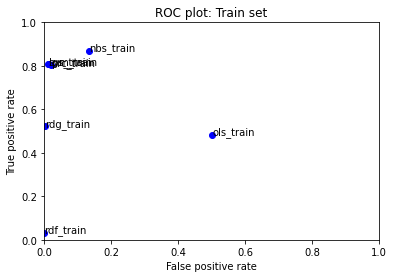

In [42]:
fits = [ols_performance_train, 
        svm_performance_train, 
        lgs_performance_train, 
        nbs_performance_train, 
        prc_performance_train, 
        rdg_performance_train, 
        rdf_performance_train
]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: Train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [43]:
#FALSE NEGATIVES
ols_predictions = ols.predict(X_train)

In [44]:
# false negatives

print("Examples of false negatives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 0):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false negatives:
276
Yeah keep warning those bad vandals you crazy motherfucker!!! 84.203.232.66
* * * * * * * * * 
735
Wow asking some one his nationality is racial, don't you think you need to grow up then. In that case every author writing article on your bloody jihad would be a hero, And every american who were killed are fools. For me you all are the same, i wont see a pen in your hand. it will be some freaking gun or grenade.
* * * * * * * * * 
2289
Shut up you fucking loser.  Get a life you fat fuck.  

````
* * * * * * * * * 
2358
antandarus where do you live im sick of you blocking me
* * * * * * * * * 
2832
YOU REALLY REALLY SUCK.
* * * * * * * * * 
3036
February 2012 (UTC)
No. you shut up, famousdog. You ARE a racist you vehemently refuse to accept the validity of a philosophical paradigm which is alien to the Western Scientific paradigm you're attached to. You will never have an accurate understanding of acupuncture if you are too xenophobic to adopt its endogen

17623
Fuck you Motha Fucka 

Penis
* * * * * * * * * 
17716
A message for you 

Fuck you!

GAYFullbuster!

Put this finger in yourasshole, bastard!
* * * * * * * * * 
18141
THE ONLY PROBLEM WITH THE HOLOCAUST IS THAT SOME JEWS SURVIVED
Other than that it was awesome!!!!
* * * * * * * * * 
18720
Psycho ==

Why do you keep telling us that our page is being vandalized!!!??? It is our page! Can we do what we want? Nobody likes you! You are such a dickhead! You lesbian butch!

~~Colleen&Vanessa;

==
* * * * * * * * * 
19513
"

I've said it before and I'll say it again. I've been dragged through WQA a couple of times that I can remember, but I'd never bother to do it to anyone else. It's just a pathetic waste of time; ""Mummy, Mummy, Malleus was rude to me."" Live with it bitch.  Fatuorum "
* * * * * * * * * 
19768
go blow your bitch GabrielF =
* * * * * * * * * 
19942
Who the hell are you 

Who are you trying to tell me I will be blocked If I dont stop   Ilovedirtbikes
* * * * * * * * * 
20

25332
the 9/11 paranoia award 

I present you with this award. Thank you for displaying you're idiocy to the world. I really am sad to hear that you have an IQ of 50. Better pack your bags before the marshons come.
* * * * * * * * * 
25565
"

Well it seems that even providing a reference, some cunt has ""blocked me from editing"". It gives further evidence to the dishonesty, unintelligence, and desire to suppress information which I expounded on ""Jimbo's"" page.
Here is the reference for ""pussy pelmet"" I gave.
http://www.independent.co.uk/life-style/under-the-counter-with-lindsay-calder-1251446.html

The block was for ""disruptive editing"", clearly this is a lie, or if an honest mistake, it is made by someone of extremely low intelligence.

If you can give an alternative believable explanation I'd like to here it."
* * * * * * * * * 
26125
you are a twat 

I am an avid World of Warcraft fan, 

yeah that figures.

You soft headed American fuckwit
* * * * * * * * * 
26801
BAN ME AND 

37304
You sodomites really know how to stick together....yech !!!! anyhow, tomorrow is another day. furthermore, i rotate ip addresses about every 2-3 days........Keep on Suckin'
* * * * * * * * * 
37348
STOP VANDALIZING! 

Seriously mang, ain't y'all got nothin' better to do than fuckin' vandalize my talk page with some error messages?  I mean, like, OMGROFL or what have you!
* * * * * * * * * 
38183
Are you a fucking dick-head?  People like you should be prohibited from editing Wikipedia.  You should first learn some history, and stop spreading your propaganda.
* * * * * * * * * 
38196
suicides

just looking at this article make me want to commit suicide.
* * * * * * * * * 
38344
Scope
Please see the link above, as I'm sure you are a fucking spastic
* * * * * * * * * 
38384
bitch 

dont ignore me.
* * * * * * * * * 
38652
tim_vickers you are a failed human thus a dud. you did not evolve from a zombie.
* * * * * * * * * 
39041
Sitush is a mofo 

Bloody bastard he is.
* * * * * * * * *

44733
If it were, you're too homo to do anything about it. A wise man long ago told me that it's so easy to be brave online. But in real person, it's a whole other ball game. It must suck being a coward.
* * * * * * * * * 
45020
Wow you play video games and you're nerdy... great time waste...;)
* * * * * * * * * 
45271
lonely

Go outside and make a friend.  You've seen all your mom's basement has to offer.
* * * * * * * * * 
45486
Ahah! The looser is still complaining me just like a kid. Now you are so happy and relaxed, eh? Poor idiot. Do you think that I care Kachin monkeys or Madai? Moron.
* * * * * * * * * 
46684
are you kidding? Wikipedia has a section on antisemitism for every major figure throughout history. this entire site is pro-israel in every regard. the biggest example is giving New Antisemtism a legitimate page while called the Israeli apartheid an analogy. You're just a zionist or Jew. Thats the ONLY explanation because normal people don't need every single person throug

62043
why did you get this IP address banned from editing wikipedia you douchen faggot go fuck your self you sutpid whore
* * * * * * * * * 
62558
"

 Are you kidding me? What does this guy have to do to have somebody shoot across his bow, once?  Murder somebody? GabeMC is out of control!! This editor has insulted many editors repeatedly. He mispells user names repeatedly, to intimidate, accuses all opposers, of his idea, as socks, calls them trolls, charges them with harrassment and is generally abusive. He incites other users to drum up charges against ""his enemies"" of this issue. He has been warned before for changing ""The"" to ""the"" in musical articles while his own launched medcom mediation is in progress, ebfore, and yet when his misbehaviour is pointed out in ANI he creates such a ruckess with sidetrack issues he gets away with more disruption and a blessing. He has had editors topic banned, adminstrators banned for a six month period and investigations into every editor th

69446
Who the HELL do you think you are? 

How dare you revert my edit to Quillacollo Province. I was making a friend smile, and you ruined it. In doing that, you also ruined my life. And my friends life. I'm going to cut your dog in half.
* * * * * * * * * 
70065
Hey asshole 

What the fuck is your problem? I'm trying to help people but you still keep fukin wit their pages. What's your deal faggot?
* * * * * * * * * 
70484
See you in two days. 

Hahahaha. You protect that Jew fag Gabe, what a fucking pussy you are. We will be back in two days to drive that little bitch out for good! 199.30.247.201
* * * * * * * * * 
70541
"

Wait.  You're not going to block me for posting an RFC?

Or did you block me just so that I couldn't go advertising the RFC on other pages where it might be relevant?

See.  There's the problem. As a non-admin, I am liable to be blackballed by admins, some of whom suffer from Projection (or do they merely think sophistry is administration?):

I performed no person

77451
Editing pages 

To anyone who reads Dmacks' talk page you will now how that there is only one person entitled to an opinion and that is Dmacks.  Hopefully he wont read anything you edited as he will just change it back.  He is very arrogant.
* * * * * * * * * 
78032
Dickhead
You know it was stupid, you know it wasn't clever. So why do it? 94.195.251.61
* * * * * * * * * 
79555
"::WTF are you an idiot? No really what is your IQ?, I only ask because there is tons of information out there that is peer reviewed and is telling us the opposite of what your alleging, then to ""support"" your claim you find a non-peer reviewed source (the only one i found that actually states anything like what u are suggesting) that you then refute. Really is this what wikipedia is coming to? We should have an IQ test before u sign up and edit? Get some facts and some references and then make your stupid claims. No animal ever has a 100% success rate in hunting or anything else for that matter, even a 6

87617
Please don't be an assclown. You've already filed a checkuser, read the result and thanked the admin that ran the check. For you to insinuate that two separate authors are one AFTER BEING TOLD that you are wrong - is the absolute height of lacking good faith. I am also shocked to see you complain about the other editor after you have so brazenly stalked and revderted my edits in the past, indeed you even followed me here to harass me in Fitna months ago after I made an edit in Scarlet Pimpernel that you disliked.  You are a real piece of work. And yes, since you seem to always run a checkuser against me and whatever editor opposes you here and they always come back negative yet you still make the same baseless charge and attack you are operating without Good Faith and have a private agenda, one that is not in keeping with the selfless NPOV standards of Wikipedia. You need to go to a quiet place and think about how others view your bullying selfish petty distortions. 75.49.223.52


98861
not know to this day what
               Devil brought them into our country. We did not fetch them
               from Jerusalem!... Yes, we have and hold them captive, as I
               would like to keep my rheumatism, and all other diseases and
               misfortunes, who must wait as a poor servant, with money and
               property and everything I have! I wish they were in hell
               with the other Jews and whomsoever they would like to have
               with them.
* * * * * * * * * 
99016
YOU SUCK YOU SUCK YOU SUCK YOU SUCK YOU SUCK YOU SUCK YOU SUCK
* * * * * * * * * 
99945
No seriously. HE IS BANNED!!! Now by saying that you are feeding the troll. Idiot.
* * * * * * * * * 
100412
guess what 

ur retarded
* * * * * * * * * 
100495
"

""If you continue to misinterpret sources even once, please note that you will be immediately blocked again."" - You know what? I tried to improve this shitty fucking article and instead of getting help, I get assholes 

114350
Yah i figured out pretty fast asshole.
* * * * * * * * * 
114394
Did you go to AussieLegend's talk page to get 1 one of our editors banned with your paranoid delusions?  Shame! Shame!
* * * * * * * * * 
114464
this edit was posted by the user of this page, you all really think you can make me not edit lol you all are funny as shit. 206.217.197.164
* * * * * * * * * 
114482
What a hypocrite !  is blatantly biased, accuses everyone of sockpuppetry, ignores other people's comments. He never adds anything useful. His edit history shows that virtually all he ever does is revert and criticise other editors. He's obviously emotionally inadequate as he hangs around WP endlessly and pointlessly. He's not only useless, he's powerless. So just get another username. It only takes 5 seconds to get around being blocked.
* * * * * * * * * 
114571
Well i think that is just plain stupid..i have seen retarted things on this site, i actually put together a nice little thing for him with ppl editin

122011
It appears you can expect lame shit like that from this editor.
* * * * * * * * * 
122179
Hey 

hey faggot, are you dead yet? or are you watching your mom getting raped by filthy pigs? which one is it? I'm coming to rape your mom and shoot your entire family. You have 1 week to live, you motherfucker.
* * * * * * * * * 
122239
Bongfag 

you are a lazy loser fucking stoner asshole who is on a pathetic wikipedia power-trip, editing bad pages even though the articles you've created suck. get out of mommy's basement and get a real hobby, like not being a stupid fucking asshole
* * * * * * * * * 
122654
hey motherfucker hurry up!
* * * * * * * * * 
122692
Please block my accont 

Block or I will put a virus into Wikipedia

76.67.105.188
* * * * * * * * * 
123255
if you block this account i will rape your children 

Piss off you fucking admin.
* * * * * * * * * 
123596
You shut your mouth. And my contributions will never be missed — as long as there are several hooligans on this site,

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [45]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1583, 'TN': 14394, 'FP': 14344, 'FN': 1594, 'Accuracy': 0.5006109979633401, 'Precision': 0.0993909713065863, 'Recall': 0.4982688070506767, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [46]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2109, 'TN': 27710, 'FP': 1028, 'FN': 1068, 'Accuracy': 0.9343255522481592, 'Precision': 0.6722983742429073, 'Recall': 0.663833805476865, 'desc': 'svm_test'}


### MODEL: logistic regression

In [47]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2118, 'TN': 27684, 'FP': 1054, 'FN': 1059, 'Accuracy': 0.9337928873570421, 'Precision': 0.667717528373266, 'Recall': 0.6666666666666666, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [48]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2505, 'TN': 24654, 'FP': 4084, 'FN': 672, 'Accuracy': 0.8509791634027887, 'Precision': 0.38017908635604797, 'Recall': 0.7884796978281398, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [49]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2115, 'TN': 27610, 'FP': 1128, 'FN': 1062, 'Accuracy': 0.9313802287325709, 'Precision': 0.6521739130434783, 'Recall': 0.6657223796033994, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [50]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1542, 'TN': 28614, 'FP': 124, 'FN': 1635, 'Accuracy': 0.9448848503838321, 'Precision': 0.9255702280912365, 'Recall': 0.48536355051935787, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [51]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 58, 'TN': 28738, 'FP': 0, 'FN': 3119, 'Accuracy': 0.9022716590944697, 'Precision': 1.0, 'Recall': 0.01825621655649984, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

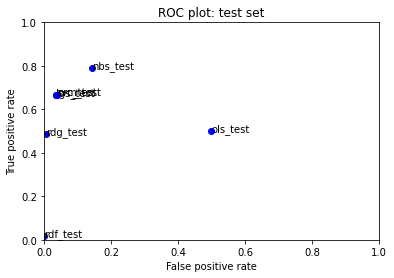

In [52]:
fits = [ols_performance_test, 
        svm_performance_test, 
        lgs_performance_test, 
        nbs_performance_test, 
        prc_performance_test, 
        rdg_performance_test, 
        rdf_performance_test
       ]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [63]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='C:/Users/geoff/PycharmProjects/machine_learning_assignment1/toxic_comments/toxiccomments_test.csv', my_random_seed=19, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 8192)
Look at a few rows of the new quantitative features: 
   excl_pct  upper_ratio  dir_response
0       0.0            4             4
1       0.0            7             0
2       0.0            4             0
3       0.0            4             2
4       0.0            1           

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [64]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = lgs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.19264970880885848


In [65]:
raw_data.head()

,id,comment_text,word_count,punc_count,excl_count,excl_pct,upper_ratio,dir_response
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0,0.0,4,4
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0,0.0,7,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0,0.0,4,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0,0.0,4,2
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0,0.0,1,0


In [66]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [67]:
my_submission.shape

(153164, 2)

In [68]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('C:/Users/geoff/Desktop/New_School/Semester_5/Machine_Learning/assignment1/iterations/toxiccomments_iter2_gstorr.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation